In [1]:
import argparse
from torch.autograd import Function
import math
import os
import pandas as pd
import numpy as np 
from scipy.special import softmax
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

# from loaders.ultrasound_dataset import USDataset
from torch.utils.data import DataLoader

from loaders.ultrasound_dataset_classification import USDataset
from transforms.ultrasound_transforms import USClassEvalTransforms
from transferModel import EfficientNetTransfer
# from transforms.ultrasound_transforms import USEvalTransforms

from sklearn.utils import class_weight
from sklearn.metrics import classification_report

from tqdm import tqdm

import pickle

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

from captum.attr import GuidedGradCam, GuidedBackprop
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from torchvision import transforms
from monai.transforms import ScaleIntensityRange

from pl_bolts.transforms.dataset_normalizations import (
    imagenet_normalization
)
import nrrd
from PIL import Image

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import torchvision.transforms as T
from PIL import Image
import cv2
# from matplotlib.backends.backend_qt4agg import FigureCanvasQTAgg as FigureCanvas

import pydicom
from sklearn.model_selection import train_test_split
import uuid
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GuidedBackpropRelu(nn.Module):
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input).to(input.device), input, positive_mask)
        return output

def register_hooks(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(GuidedBackpropRelu())

def compute_gradcam(model, last_conv_layer, input_tensor, target_class):
    model.eval()
    features = None
    gradients = None
    
    def save_features(module, input, output):
        nonlocal features
        features = output
        
    def save_gradients(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]
    print("Last conv layer type: ", type(last_conv_layer))   
    last_conv_layer.register_forward_hook(save_features)
    last_conv_layer.register_backward_hook(save_gradients)
    
    model.zero_grad()
    output = model(input_tensor)
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().cuda()
    one_hot_output[0][target_class] = 1
    
    output.backward(gradient=one_hot_output, retain_graph=True)
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(features.shape[1]):
        features[0][i] *= pooled_gradients[i]
        
    grad_cam = F.relu(torch.mean(features, dim=1)).squeeze()
    grad_cam = F.interpolate(grad_cam.unsqueeze(0).unsqueeze(0), size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
    
    return grad_cam

def guided_backprop(model, input_tensor, target_class):
    model.eval()

    # Register hooks for ReLU layers
    def relu_hook_function(module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(relu_hook_function)
            
    # Forward pass
    model.zero_grad()
    input_tensor = input_tensor.requires_grad_()  # Set requires_grad to True.
    output = model(input_tensor)
    
    # Backward pass
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_().cuda()
    one_hot_output[0][target_class] = 1
    output.backward(gradient=one_hot_output)
    
    return input_tensor.grad.data  # This will contain the guided backpropagation gradients

# def normalize(tensor):
#     tensor = tensor - tensor.min()
#     tensor = tensor / tensor.max()
#     return tensor

# def generate_heatmap(image, guided_gradcam):
#     guided_gradcam = normalize(guided_gradcam)
#     heatmap = cv2.applyColorMap(np.uint8(255 * guided_gradcam), cv2.COLORMAP_JET)
#     heatmap = np.float32(heatmap) / 255
#     cam_heatmap = heatmap + np.float32(image)
#     cam_heatmap = cam_heatmap / np.max(cam_heatmap)
#     return np.uint8(255 * cam_heatmap)

# def normalize(tensor):
#     tensor = tensor - tensor.min()
#     tensor = tensor / tensor.max()
#     return tensor

# def tensor_to_image(tensor):
#     # Convert the tensor to a PIL image and then to a NumPy array
#     tensor = tensor.squeeze().cpu().detach()
#     if len(tensor.shape) == 3:
#         tensor = tensor.permute(1, 2, 0)
#     image = tensor.numpy()
#     if image.shape[-1] == 3:
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     return image

# def visualize(guided_gradcam, original_image_tensor):
#     # Normalize the guided Grad-CAM
#     guided_gradcam = normalize(guided_gradcam.cpu().detach())
    
#     # Convert original image tensor to NumPy array
#     original_image = tensor_to_image(original_image_tensor.cpu())
    
#     # Resize guided Grad-CAM to the original image size
#     print("guided_gradcam shape:", guided_gradcam.numpy().shape)
#     print("original_image shape:", original_image.shape)
#     print("Resizing to:", (original_image.shape[1], original_image.shape[0], original_image.shape[2]))
#     guided_gradcam = guided_gradcam.cpu().numpy()
#     # original_image = original_image.cpu().numpy()
#     guided_gradcam = cv2.resize(guided_gradcam, (original_image.shape[1], original_image.shape[0]))

#     # Overlay the guided Grad-CAM on the original image
#     overlay = np.uint8(255 * guided_gradcam)
#     heatmap = cv2.applyColorMap(overlay, cv2.COLORMAP_JET)
#     output = cv2.addWeighted(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

#     plt.figure(figsize=(10, 10))

#     plt.subplot(131)
#     plt.title('Original Image')
#     plt.imshow(original_image)
#     plt.axis('off')

#     plt.subplot(132)
#     plt.title('Guided Grad-CAM')
#     plt.imshow(guided_gradcam, cmap='jet')
#     plt.axis('off')

#     plt.subplot(133)
#     plt.title('Overlay')
#     plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
#     plt.axis('off')

#     # plt.show()
#     

def normalize(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

def tensor_to_image(tensor):
    tensor = tensor.squeeze().cpu().detach().numpy()
    if len(tensor.shape) == 3:
        tensor = np.transpose(tensor, (1, 2, 0))
    return tensor

def visualize(original_image_tensor, guided_gradcam):
    # Normalize the guided Grad-CAM tensor
    guided_gradcam = normalize(guided_gradcam)
    guided_gradcam = guided_gradcam.squeeze().detach().cpu()
    print("Type of guidedgrad: ", type(guided_gradcam))
    guided_gradcam = torch.reshape(guided_gradcam, (256,256,3))

    # Convert the original image tensor to a NumPy array
    original_image = tensor_to_image(original_image_tensor)

    # Visualize
    plt.figure(figsize=(10, 5))
    print("Shape of original Image:", original_image.shape)
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image, cmap='gray' if len(original_image.shape) == 2 else None)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Guided Grad-CAM')
    plt.imshow(guided_gradcam.squeeze().detach().cpu(), cmap='jet')
    plt.axis('off')

    plt.show()
    # plt.savefig("/mnt/raid/home/ayrisbud/us-famli-pl/src/gradcamOutput/tmpImg.png")



# # Assume `model` is your pre-trained model and `input_image` is your normalized input tensor
# # target_class is the index of the class you want to visualize
# model = ... # Your pretrained model
# input_image = ... # Your input image tensor of shape [1, C, H, W]
# target_class = ... # Index of target class
# target_layer = ... # The layer you're interested in, e.g., model.layer4[-1]

# grad_cam = compute_gradcam(model, input_image, target_class, target_layer)
# guided_bp = guided_backprop(model, input_image, target_class)

# # Combine to get Guided Grad-CAM
# guided_gradcam = grad_cam * guided_bp


In [12]:
def runGGC(myMountPoint, myCSV, myImgCol, myBatchSize, myNumWorkers, myNn, myModel):
    if(os.path.splitext(myCSV)[1] == ".csv"):        
            df_test = pd.read_csv(os.path.join(myMountPoint, myCSV))
    else:        
        df_test = pd.read_parquet(os.path.join(myMountPoint, myCSV))
            
    test_ds = USDataset(df_test, label_column = None, img_column=myImgCol, transform=USClassEvalTransforms(), mount_point=myMountPoint)
    test_loader = DataLoader(test_ds, batch_size=myBatchSize, shuffle=False, num_workers=myNumWorkers, pin_memory=True, prefetch_factor=4)
    model = EfficientNetTransfer(base_encoder=myNn, ckpt_path="/mnt/raid/C1_ML_Analysis/train_output/classification/extract_frames_blind_sweeps_c1_30082022_wscores_train_train_sample_clean_feat/epoch=9-val_loss=0.27.ckpt").load_from_checkpoint(myModel)
    
    model.eval()
    model.cuda()
    target_layer_name = model.efficientnet.convnet.features[8][0]
    print("Type of target layer name: ", type(target_layer_name))
    # guidedGradcam = GuidedGradCAMMan(model, target_layer_name)
    # with torch.no_grad():
    predictions = []
    probs = []
    features = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    # for idx, X in tqdm(enumerate(test_loader), total=len(test_loader)):
    for idx, X in pbar:
        X = X.cuda().contiguous()
        myPred = model(X)
        myPredSigmoid = nn.Softmax(dim=1)(myPred)
        converted_tensor = torch.where(myPredSigmoid >= 0.08, torch.tensor(1), torch.tensor(0))
        converted_tensor = converted_tensor.cpu().numpy()
        myPred = myPred.cuda()
        print("ConvertedTensor: ", converted_tensor)
        print("ConvertedTensorType: ", type(converted_tensor))
        toRunIndices = [index for index, value in enumerate(converted_tensor[0]) if value == 1]
        for i in range(len(toRunIndices)):
            grad_cam = compute_gradcam(model=model, input_tensor=X, target_class=toRunIndices[i], last_conv_layer=target_layer_name)
            guided_bp = guided_backprop(model=model, input_tensor=X, target_class=toRunIndices[i])
            # print(type(grad_cam))
            # print(type(guided_bp))
            guided_gradcam = grad_cam * guided_bp   
            # print(type(guided_gradcam))  
            # print(guided_gradcam.shape) 
            # print(X.shape)
            # guided_gradcam = guided_gradcam.detach().cpu().numpy()
            # X = X.detach().cpu().numpy()
            visualize(guided_gradcam=guided_gradcam, original_image_tensor=X)  
        break

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../C1_ML_Analysis/train_output/classification/extract_frames_blind_sweeps_c1_30082022_wscores_train_train_sample_clean_feat/epoch=9-val_loss=0.27.ckpt`


CKPT PATH:  /mnt/raid/C1_ML_Analysis/train_output/classification/extract_frames_blind_sweeps_c1_30082022_wscores_train_train_sample_clean_feat/epoch=9-val_loss=0.27.ckpt


Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../C1_ML_Analysis/train_output/classification/extract_frames_blind_sweeps_c1_30082022_wscores_train_train_sample_clean_feat/epoch=9-val_loss=0.27.ckpt`


CKPT PATH:  /mnt/raid/C1_ML_Analysis/train_output/classification/extract_frames_blind_sweeps_c1_30082022_wscores_train_train_sample_clean_feat/epoch=9-val_loss=0.27.ckpt
Type of target layer name:  <class 'torch.nn.modules.conv.Conv2d'>


  0%|          | 0/2239 [00:00<?, ?it/s]/mnt/raid/home/ayrisbud/anaconda3/envs/torch_us/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


ConvertedTensor:  [[1 0 0 1 0 0 0]]
ConvertedTensorType:  <class 'numpy.ndarray'>
Last conv layer type:  <class 'torch.nn.modules.conv.Conv2d'>
Type of guidedgrad:  <class 'monai.data.meta_tensor.MetaTensor'>
Shape of original Image: (256, 256, 3)
Last conv layer type:  <class 'torch.nn.modules.conv.Conv2d'>
Type of guidedgrad:  <class 'monai.data.meta_tensor.MetaTensor'>
Shape of original Image: (256, 256, 3)


  0%|          | 0/2239 [00:00<?, ?it/s]


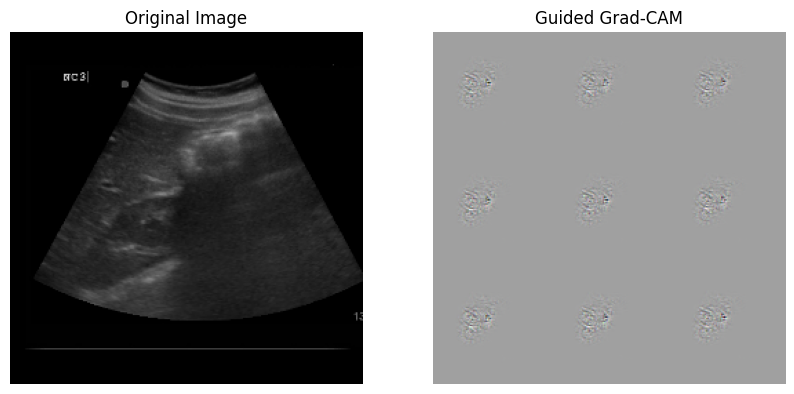

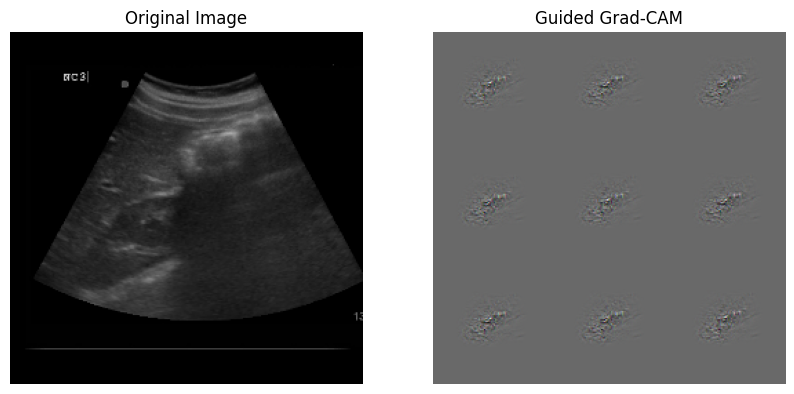

In [13]:
myCSV = "/mnt/raid/home/ayrisbud/us-famli-pl/src/annotatedTrainConcise.csv"
myModel = "/mnt/raid/home/ayrisbud/train_output/classification/epoch=21-val_loss=1.06.ckpt"
myImgCol = "img_path"
myClassCol = "pred_cluster"
myNn = "efficientnet_b0"    
myOutFile = "./myOutput"
myBatchSize = 1
myNumWorkers = 16
myMountPoint = "/mnt/raid/C1_ML_Analysis/"
myExtractFeatures = False
myLabels = True
runGGC(myMountPoint, myCSV, myImgCol, myBatchSize, myNumWorkers, myNn, myModel)